# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState  

Загрузим каждый регион в отдельный датафрейм.

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных нет. Типы данных и названия колонок верны.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

Признаки для модели:

- f0;
- f1;
- f2.

Целевой признак:

- product.

Удаляем столбец id, он не нужен для моделей

In [9]:
df1 = df1.drop('id', axis=1)
df2 = df2.drop('id', axis=1)
df3 = df3.drop('id', axis=1)

Проверка дубликатов

In [10]:
print('Количество полных дубликатов объектов по региону 1:', df1.duplicated().sum())
print('Количество полных дубликатов объектов по региону 2:', df2.duplicated().sum())
print('Количество полных дубликатов объектов по региону 3:', df3.duplicated().sum())

Количество полных дубликатов объектов по региону 1: 0
Количество полных дубликатов объектов по региону 2: 0
Количество полных дубликатов объектов по региону 3: 0


Дубликатов нет

ПРоверка пропусков

In [11]:
if (df1.isnull().sum().sum() + df2.isnull().sum().sum() + df3.isnull().sum().sum()) == 0:
    print('Nan - не обнаружено в сетах')

Nan - не обнаружено в сетах


пропусков нет

Распределение признаков:

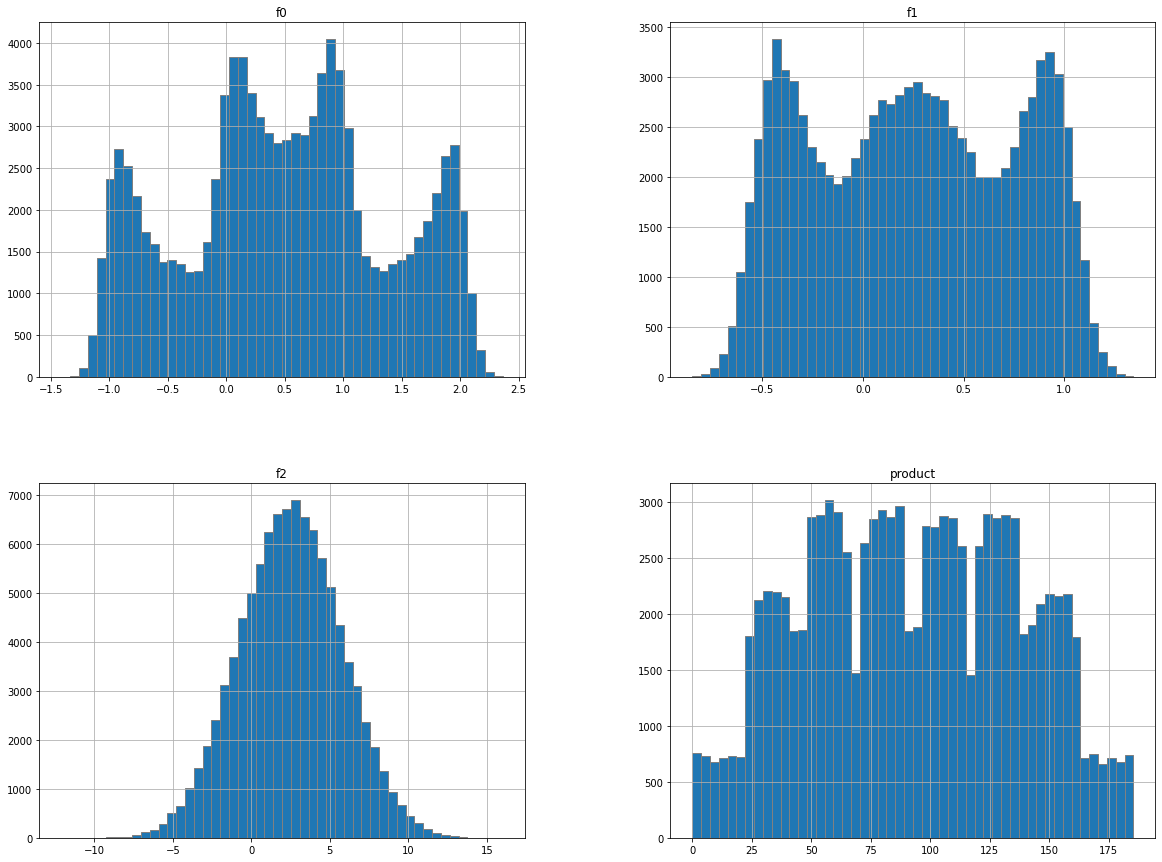

In [12]:
df1.hist(bins=50, figsize=(20,15), edgecolor='grey', linewidth=1)
plt.show()

На первый взгляд здесь все ок

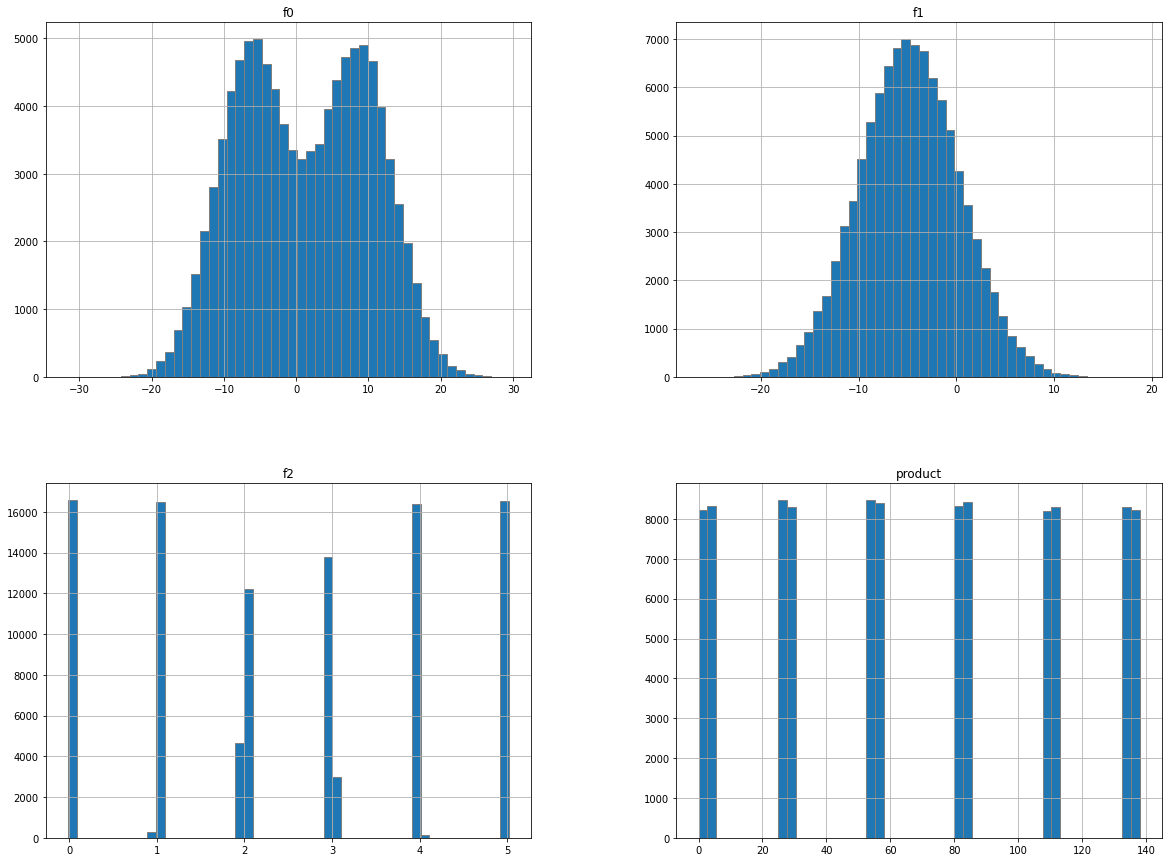

In [13]:
df2.hist(bins=50, figsize=(20,15), edgecolor='grey', linewidth=1)
plt.show()

Значения признаков f2 и product у второго региона довольна подозрительно имеют повторяющиеся значения - возможно эта ошибка сбора данных. Следует уточнить у коллег.

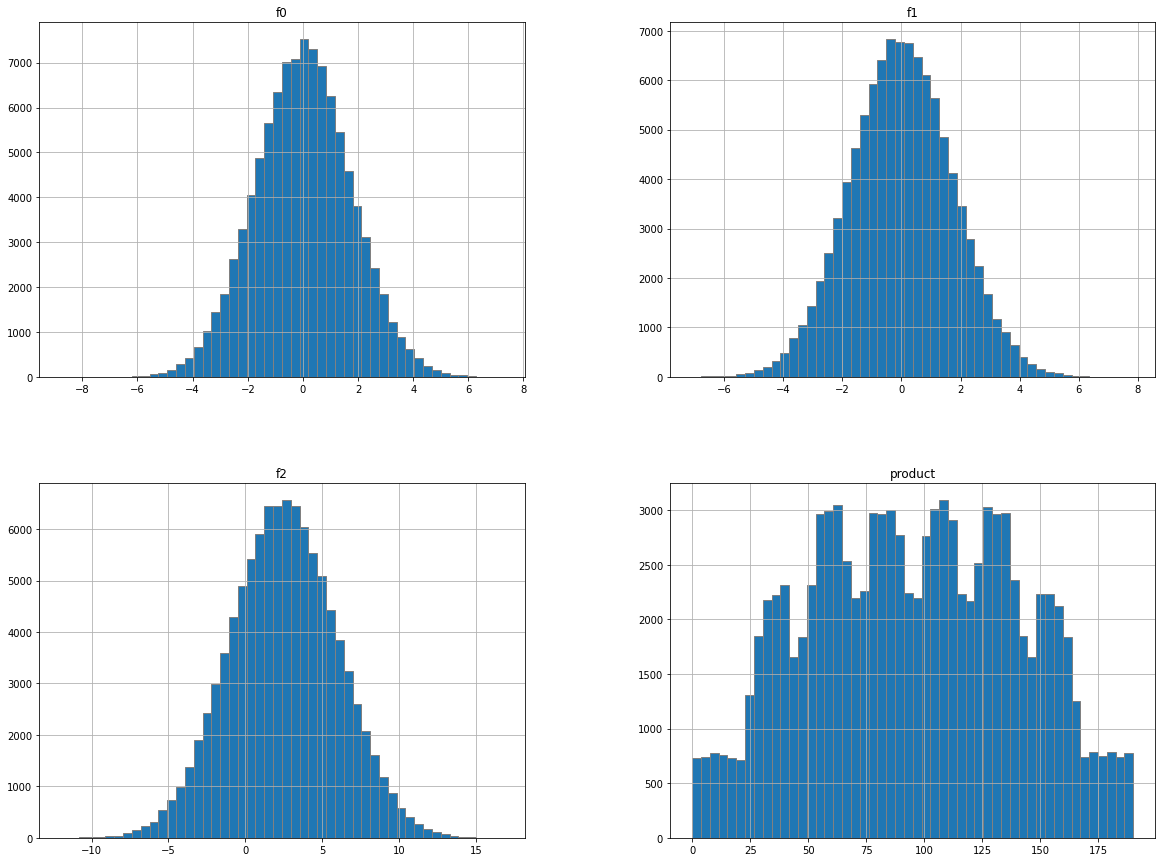

In [14]:
df3.hist(bins=50, figsize=(20,15), edgecolor='grey', linewidth=1)
plt.show()

Здесь также как и в df1 все окей.

Исследуем корреляцию  между признаками 

In [15]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [16]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [17]:
df3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Наблюдается корреляция между признаками f2 и product - самая значительная у второго сета, где были обнаружены идентичные значения по продукции.  

**Вывод**

Результаты первичного анализа:

- Пропусков нет
- Типы столбцов верны
- Названия столбцов верны
- Дубликатов нет
- Исследована корреляциямежду признаками
- Данные готовы к обучению

## Обучение и проверка модели

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

Готовим выборки для обучения. Разбиваем на целевой признак и признаки

In [18]:
features_1 = df1.drop(['product'], axis=1)
target_1 = df1['product']

features_2 = df2.drop(['product'], axis=1)
target_2 = df2['product']

features_3 = df3.drop(['product'], axis=1)
target_3 = df3['product']

Разбиваем на обучающую и валидационную выборку

In [19]:
train_features_1, valid_features_1, train_target_1, valid_target_1 = train_test_split(features_1,
                                                                                      target_1,
                                                                                      test_size=.25,
                                                                                      random_state=42)
train_features_2, valid_features_2, train_target_2, valid_target_2 = train_test_split(features_2,
                                                                                      target_2,
                                                                                      test_size=.25,
                                                                                      random_state=42)
train_features_3, valid_features_3, train_target_3, valid_target_3 = train_test_split(features_3,
                                                                                      target_3,
                                                                                      test_size=.25,
                                                                                      random_state=42)

### Первый регион

Обучаем моделью линейной регрессии

In [20]:
model_reg_1 = LinearRegression().fit(train_features_1, train_target_1)

Предсказания модели на валидационной выборке

In [21]:
prediction_1 = model_reg_1.predict(valid_features_1)

In [22]:
print('Средний запас сырья:', prediction_1.mean(),
      'RMSE:', np.sqrt(mean_squared_error(prediction_1, valid_target_1)))

Средний запас сырья: 92.39879990657768 RMSE: 37.75660035026169


### Второй регион

In [23]:
model_reg_2 = LinearRegression().fit(train_features_2, train_target_2)
prediction_2 = model_reg_2.predict(valid_features_2)
print('Средний запас сырья:', prediction_2.mean(),
      'RMSE:', np.sqrt(mean_squared_error(prediction_2, valid_target_2)))

Средний запас сырья: 68.71287803913762 RMSE: 0.890280100102884


У данных второго региона подозрительное распределение, что было заметно выше. К предсказаниям стоит относиться с долей сомнения и уточнить у коллег причину, почему данные распределены таким образом по целевому показателю и признаку f2

### Третий регион

In [24]:
model_reg_3 = LinearRegression().fit(train_features_3, train_target_3)
prediction_3 = model_reg_3.predict(valid_features_3)
print('Средний запас сырья:', prediction_3.mean(),
      'RMSE:', np.sqrt(mean_squared_error(prediction_3, valid_target_3)))

Средний запас сырья: 94.77102387765939 RMSE: 40.145872311342174


In [25]:
data_rmse = {'Первый регион':np.array([92.39, 37.757]),'Второй регион':np.array([68.71,0.890]),'Третий регион':np.array([94.77,40.145])}
data = pd.DataFrame(data_rmse,index=['Средний запас сырья','RMSE'])
data

,Первый регион,Второй регион,Третий регион
Средний запас сырья,92.390,68.71,94.770
RMSE,37.757,0.89,40.145


**Вывод**

- в среднем модель предсказывает 92.4 тыс. баррелей нефти по первому региону. квадратный корень из среднеквадратичной ошибки - 37.757. Лучший результат именно в первом регионе.
- в среднем модель предсказывает 68.71 тыс. баррелей нефти по второму региону. квадратный корень из среднеквадратичной ошибки - 0.890
- в среднем модель предсказывает 94.77 тыс. баррелей нефти по третьему региону. средняя абсолютная ошибка для первого региона - 32.897. Результаты немногим хуже, чем у первого региона

## Подготовка к расчёту прибыли

Назначение переменных для ключевых параметров

In [26]:
PRE_MAX_POINTS = 500 # При разведке региона проводится исследование 500 точек.
FINAL_MAX_POINTS = 200 # лучшие точки
BUDGET = 10*10**9 # Бюджет на разработку месторождений — 10 млрд рублей
BARREL = 4500 # Один баррель сырья приносит 4500 рублей прибыли.
PRICE_PER_1000B = 450*10**3

Расчитаем минимальный запас нефти на скважину (точку безубыточности)

In [27]:
well_price = int(BUDGET / FINAL_MAX_POINTS)
print('Стоимость бурения одной скважины  : {}'.format(well_price))
oil_stock = well_price / PRICE_PER_1000B
print('Минимальный средний запас нефти на скважину, тыс. бар.: {:.2f}'.format(oil_stock))

Стоимость бурения одной скважины  : 50000000
Минимальный средний запас нефти на скважину, тыс. бар.: 111.11


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [28]:
data

,Первый регион,Второй регион,Третий регион
Средний запас сырья,92.390,68.71,94.770
RMSE,37.757,0.89,40.145


**Вывод**

Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1). В тоже время максимальный средний объем в регионах равен 94.7.  Средний запас сырья в скважинах регионов меньше, чем точка безубыточности. Наибоьшая доля скважин выше точки безубыточности будет находится в первом и третьем регионе.

## Расчёт прибыли и рисков 

Функция расчета прибыли

In [29]:
def revenue(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target.loc[predict_sorted.index.to_list()][:200]
    return (selected.sum() * PRICE_PER_1000B) - BUDGET

Функция Bootstrap

In [30]:
def bootstrap(target_test, predict, region):
    state = np.random.RandomState(12345)
    values = []
    target = target_test.reset_index(drop=True)
    predictions = pd.Series(predict)
    count = 0 
    for i in range(1000):
 
        target_subsample = target.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index.to_list()]
        value = revenue(target_subsample, predictions_subsample)
        values.append(value)
        
        if value < 0: 
            count += 1 
        
    risk = count / 1000
 
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975) 
    
    print('Средняя прибыль по', region, 'региону составляет:', round(values.mean(), 2), 'рублей, с риском', 
          round(risk * 100, 2), '%')
    print('Доверительный интервал в регионе составляет от', round(lower, 2),'до', round(upper, 2))

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона

In [31]:
bootstrap(valid_target_1, prediction_1, 1)

Средняя прибыль по 1 региону составляет: 435933772.14 рублей, с риском 6.1 %
Доверительный интервал в регионе составляет от -116231612.78 до 966504180.71


In [32]:
bootstrap(valid_target_2, prediction_2, 2)

Средняя прибыль по 2 региону составляет: 489661254.41 рублей, с риском 1.1 %
Доверительный интервал в регионе составляет от 55116177.27 до 905762650.42


In [33]:
bootstrap(valid_target_3, prediction_3, 3)

Средняя прибыль по 3 региону составляет: 403687927.86 рублей, с риском 7.1 %
Доверительный интервал в регионе составляет от -153116984.76 до 952887416.71


**Вывод**

После расчёта рисков и выручки можно заметить, что второй регион показывает наиболее выгодный вероятный результат. Самая высокая средняя выручка, а так же самые минимальные риски. Однако по второму региону следует уточнить данные. Если выбирать из первого и третьего региона, то лучшим будет первый.

**Общий вывод**

При выполнении проекта было выполнено:

- Изучины данные. Проведена подготовка данных к моделированию.
- Обучена модель для каждого региона df1, df2 и df3.
- Составлена функция расчета прибыли в регионе.
- Посчитана прибыль и риски за каждый регион и обоснован выбор региона.
- Второй регион определен одним из лучших по показателям предсказывания и представленным данным, хотя данные по второму региону не выглядят нормально распределенными.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован